### University of Washington: Machine Learning and Statistics 

# Lecture 10: Hierarchical Bayesian Modeling

Andrew Connolly and Mario Juric

##### Resources for this notebook include:
- [Textbook](https://press.princeton.edu/books/hardcover/9780691198309/statistics-data-mining-and-machine-learning-in-astronomy) Chapter 5.9
- [astroML website](https://www.astroml.org/index.html)
- [pymc3 documentation](https://docs.pymc.io/en/v3/)
- [Why hierarchical models are awesome, tricky, and Bayesian](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/) by Thomas Wiecki

This notebook is developed based on material from A. Connolly, Z. Ivezic, M. Juric, S. Portillo, G. Richards, B. Sipocz, J. VanderPlas, D. Hogg, Killian Weinberger and many others.

The notebook and associated material are available from [github](https://github.com/uw-astro/astr-598a-spr24).

The jupyterhub with the software installed is available at [jupyterhub](https://jupyter.rttl.uw.edu/2024-spring-astr-598-a).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
from astroML.plotting.mcmc import convert_to_stdev

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


## What is a hierarchical Bayesian model?

Let's start with a simple example - imagine we've measured the radial velocity of a star to be $v = 100 \frac{\rm km}{\rm s}$ with a Gaussian measurement error of $\sigma_v = 40 \frac{\rm km}{\rm s}$. Now imagine we have prior information that this star is a member of a cluster with systemic radial velocity $\mu = 50 \frac{\rm km}{\rm s}$ and radial velocity dispersion $\sigma = 20 \frac{\rm km}{\rm s}$. If we can assume that the radial velocities of stars in this cluster follow a Gaussian distribution, what is the best estimate for the radial velocity of the observed star?

Before we observe the star, we assume it is a typical member of the cluster, so our prior on its velocity is:
$$ p(v^* \mid \mu, \sigma) = \mathcal{N}(\mu, \sigma^2)[v^*]$$
The likelihood of our observation, given some true velocity $v^*$, is:
$$ p(v \mid v^*, e) = \mathcal{N}(v^*, e^2)[v]$$
Our Gaussian prior is a conjugate prior to our Gaussian likelihood (see textbook section 5.2.3), so the posterior is also a Gaussian:
$$ p(v^* \mid v, e, \mu, \sigma) = \frac{p(v \mid v^*, e) \times p(v^* \mid \mu, \sigma)}{Z} = \mathcal{N}\left(\frac{v/e^2 + \mu/\sigma^2}{1/e^2 + 1/\sigma^2}, \frac{1}{1/e^2 + 1/\sigma^2}\right)[v^*]$$
Plugging the numbers in, we get $\mathcal{N}\left(60 \frac{\rm km}{\rm s}, (17.8 \frac{\rm km}{\rm s})^2\right)$ - this estimate is much different from the measurement $100 \frac{\rm km}{\rm s}$ and has a much lower error than our measurement error , what's going on? We assume we knew the systemic velocity and velocity dispersion of the cluster, so this prior acts like another measurement, and is upweighted because it is more precise than our direct measurement of the star. The mean of the posterior is **biased** towards the cluster systemic velocity, and in exchange for accepting this bias, we get an estimate with much less **variance**. This effect is called **borrowing strength** in statistics.

If we know that the cluster has a Gaussian velocity distribution, we can still use that distribution as a prior, even if we don't know the systemic velocity $\mu$ or velocity dispersion $\sigma$. These parameters form part of the prior, so they are **hyperparameters**, and priors on them are **hyperpriors**:
$$ p(v^*, \mu, \sigma \mid v, e) \propto p(v \mid v^*, e) \times p(v^* \mid \mu, \sigma) \times p(\mu, \sigma) \\
{\rm posterior} \propto {\rm likelihood} \times {\rm prior} \times {\rm hyperprior}$$
Clearly, estimating $\mu$ and $\sigma$ with only one star will not go well, so this setup is most useful if we have measurements of many stars from the same cluster that can all constrain the cluster parameters, and in turn, borrow strength from each other. Let's generalize to many stars with independent measurements:
$$ p(\{v_i^*\}, \mu, \sigma \mid \{v_i\}, \{e_i\}) \propto \prod_i \left[p(v_i \mid v_i^*, e_i) \times p(v_i^* \mid \mu, \sigma) \right] \times p(\mu, \sigma) $$

## Marginalizing over parameters in a hierarchical model

Because we have an analytic posterior distribution for all the parameters $v_i$ for fixed values of the hyperparameters $\mu$, $\sigma$, we can analytically marginalize over the parameters and get a posterior on the hyperparameters directly:
$$ p(\mu, \sigma \mid \{v_i\}, \{e_i\} ) = \int p(\{v_i^*\}, \mu, \sigma \mid \{v_i\}, \{e_i\}) \, \{dv_i^*\} \\
= \int \frac{\prod_i \left[p(v_i \mid v_i^*, e_i) \times p(v_i^* \mid \mu, \sigma) \right] \times p(\mu, \sigma)}{\mathcal{Z}} \, \{dv_i^*\} \\
= \frac{p(\mu, \sigma)}{\mathcal{Z}} \prod_i \int p(v_i \mid v_i^*, e_i) \times p(v_i^* \mid \mu, \sigma) \, dv_i^* = \frac{p(\mu, \sigma)}{\mathcal{Z}} \prod_i Z_i(\mu, \sigma)$$
where $Z_i$ is the likelihood for star $i$ marginalized over its true velocity $v_i^*$, that is, $p(v_i \mid e_i, \mu, \sigma)$:
$$ Z_i(\mu, \sigma) = \int p(v_i \mid v_i^*, e_i) \times p(v_i^* \mid \mu, \sigma) \, dv_i^* = \frac{1}{\sqrt{2 \pi (e_i^2 + \sigma^2)}} \exp \left( -\frac{(v_i - \mu)^2}{2 (e_i^2 + \sigma^2)} \right) = \mathcal{N}(\mu, e_i^2 + \sigma^2)[v_i]$$
This makes sense, as each star's true velocity is dispersed from the mean $\mu$ by the cluster velocity dispersion $\sigma$, and then the measurement is further dispersed by the measurement error $e_i$. Libraries like `pymc3` can handle these models without marginalization, but it is good to know how to do it by hand, as we will see.

## First attempt at fitting a hierarchical model

Let's check out the mock data set from the textbook:

In [2]:
# adapted from textbook figure 5.27
np.random.seed(2)    # for repeatability

N = 10               # number of measured stars
mu_true = -50.0      # km/s, true systemic velocity
sigma_true = 20.0    # km/s, true velocity dispersion
ei = 10 + 40 * np.random.random(N)   # n.b. heteroscedastic errors
# generate measurements
xi = np.random.normal(mu_true, np.sqrt(sigma_true ** 2 + ei ** 2))

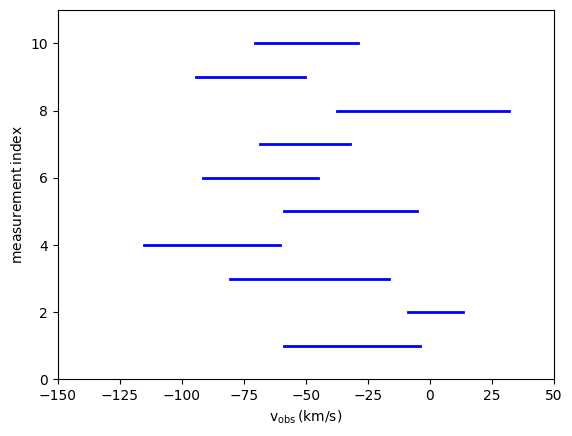

In [3]:
plt.xlabel(r'${\rm v_{obs}} \, {\rm (km/s)}$')
plt.ylabel(r'${\rm measurement \, index}$')
plt.xlim(-150, 50)
plt.ylim(0, 11)
# mark +-error ranges
for i in range(0, N):
    xL = xi[i] - ei[i]
    xR = xi[i] + ei[i]
    plt.plot([xL, xR], [i + 1, i + 1], 'b', lw=2)
plt.show()

The `pymc3` code follows the structure of our likelihood and priors:
- hyperpriors $p(\mu)$ and $p(\sigma)$, followed by
- the priors $p(v_i^* \mid \mu, \sigma)$, followed by
- the likelihood $p(v_i \mid v_i^*, e_i)$

In [4]:
with pm.Model():
    # hyperprior
    mu = pm.Uniform('mu', -100, 0) # systemic velocity of the cluster in km/s
    log_sigma = pm.Uniform('log_sigma', 0, 5) # log of velocity dispersion in km/s
    
    # prior
    v_true = pm.Normal('v*', mu=mu, sigma=np.exp(log_sigma), shape=xi.shape) # true velocities are drawn from Gaussian(mu, sigma^2)
    
    #likelihood
    v = pm.Normal('v', mu=v_true, sigma=ei, observed=xi) # xi are measurements of true velocities with gaussian errors ei
    
    #sample!
    trace1 = pm.sample(draws=10000, tune=1000, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [v*, log_sigma, mu]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
There were 744 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.40926373688311435, but should be close to 0.8. Try to increase the number of tuning steps.
There were 755 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [5]:
def plot_posterior(trace):
    pm.plot_trace(trace)
    plt.show()
        
    # adapted from textbook figure 5.22
    # compute histogram of results to plot below
    L_MCMC, mu_bins, sigma_bins = np.histogram2d(trace['mu'],
                                                 trace['log_sigma'],
                                                 bins=(np.linspace(-100, 0, 41),
                                                       np.linspace(0, 5, 41)))
    L_MCMC[L_MCMC == 0] = 1E-16  # prevents zero-division errors

    hist_mu, bins_mu = np.histogram(trace['mu'], bins=mu_bins, density=True)
    hist_sigma, bins_sigma = np.histogram(trace['log_sigma'],
                                          bins=sigma_bins, density=True)

    def log_marginal_posterior(xi, ei, mu, log_sigma):
        wi = 1/(ei[:,None]**2 + np.exp(log_sigma[None,:])**2)
        return np.sum(0.5*np.log(wi[:,:,None]) - 0.5*wi[:,:,None]*(xi[:,None,None] - mu[None,None,:])**2, axis=0)

    # ----------------------------------------------------------------------
    # Compute likelihood analytically for comparison
    mu = np.linspace(-100, 0, 70)
    log_sigma = np.linspace(0, 5, 70)
    logL = log_marginal_posterior(xi, ei, mu, log_sigma)
    logL -= logL.max()

    p_mu = np.exp(logL).sum(0)
    p_mu /= p_mu.sum() * (mu[1] - mu[0])

    p_sigma = np.exp(logL).sum(1)
    p_sigma /= p_sigma.sum() * (log_sigma[1] - log_sigma[0])

    hist_mu, bins_mu = np.histogram(trace['mu'], bins=mu_bins, density=True)
    hist_sigma, bins_sigma = np.histogram(trace['log_sigma'],
                                          bins=sigma_bins, density=True)


    # ----------------------------------------------------------------------
    # plot the results
    fig = plt.figure(figsize=(10, 10))

    # first axis: likelihood contours
    ax1 = fig.add_axes((0.4, 0.4, 0.55, 0.55))
    ax1.xaxis.set_major_formatter(plt.NullFormatter())
    ax1.yaxis.set_major_formatter(plt.NullFormatter())

    ax1.contour(mu, log_sigma, convert_to_stdev(logL),
                levels=(0.683, 0.955, 0.997),
                colors='b', linestyles='dashed')

    ax1.contour(0.5 * (mu_bins[:-1] + mu_bins[1:]),
                0.5 * (sigma_bins[:-1] + sigma_bins[1:]),
                convert_to_stdev(np.log(L_MCMC.T)),
                levels=(0.683, 0.955, 0.997),
                colors='k')
    
    ax1.scatter([mu_true], [np.log(sigma_true)], c='r')

    # second axis: marginalized over mu
    ax2 = fig.add_axes((0.1, 0.4, 0.29, 0.55))
    ax2.xaxis.set_major_formatter(plt.NullFormatter())
    ax2.plot(hist_sigma, 0.5 * (bins_sigma[1:] + bins_sigma[:-1]
                                - bins_sigma[1] + bins_sigma[0]),
             '-k', drawstyle='steps')
    ax2.plot(p_sigma, log_sigma, '--b')
    ax2.axhline(np.log(sigma_true), c='r')
    ax2.set_ylabel(r'$\log \sigma$')
    ax2.set_ylim(0, 5)

    # third axis: marginalized over sigma
    ax3 = fig.add_axes((0.4, 0.1, 0.55, 0.29))
    ax3.yaxis.set_major_formatter(plt.NullFormatter())
    ax3.plot(0.5 * (bins_mu[1:] + bins_mu[:-1]), hist_mu,
             '-k', drawstyle='steps-mid')
    ax3.plot(mu, p_mu, '--b')
    ax3.axvline(mu_true, c='r')
    ax3.set_xlabel(r'$\mu$')
    plt.xlim(-100, 0)

    plt.show()

The chain has samples of $\{v_i^*\}$, as well as $\mu$ and $\sigma$. We can see the borrowing power effect in the posterior estimates of the velocity of each star in green, and the marginal posteriors on $\mu$ and $\sigma$ agree with the analytic derivation in blue. But the sampler doesn't do well with the outer contours of the joint $\mu,\sigma$ posterior at small $\sigma$:

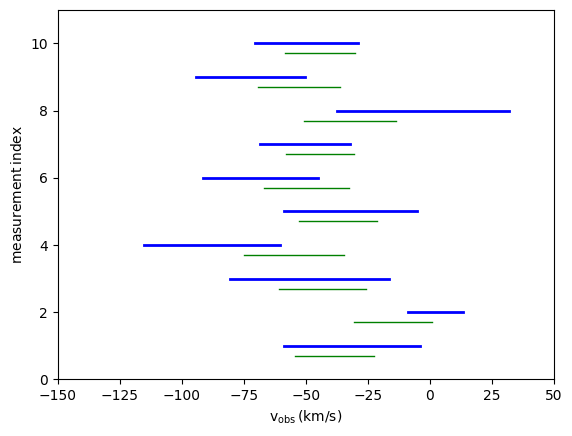

/opt/conda/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


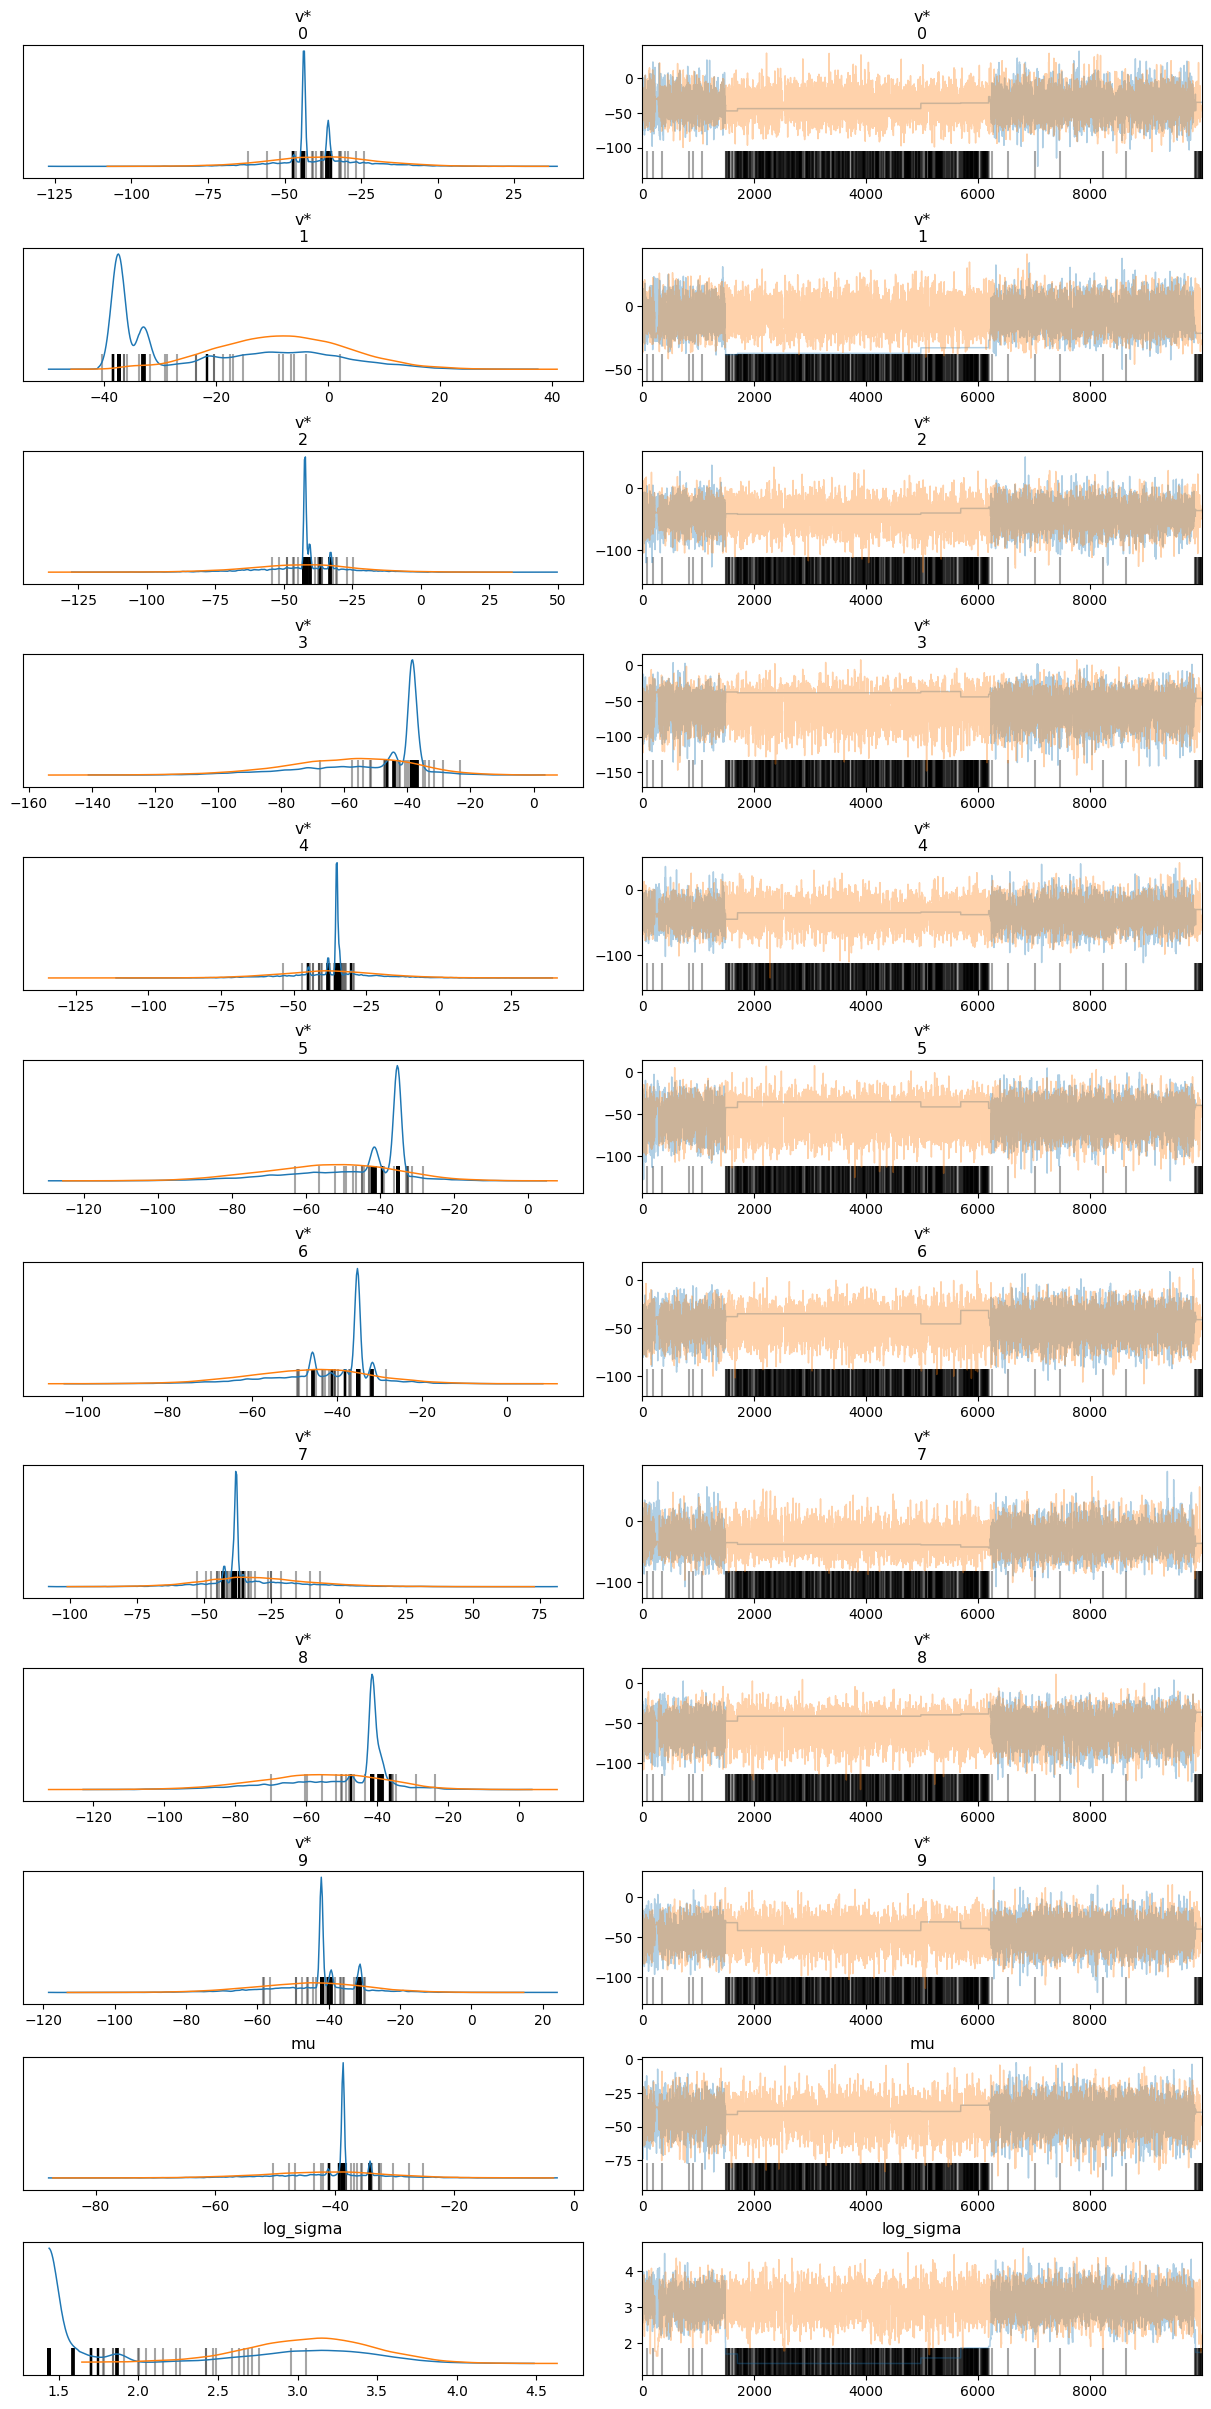

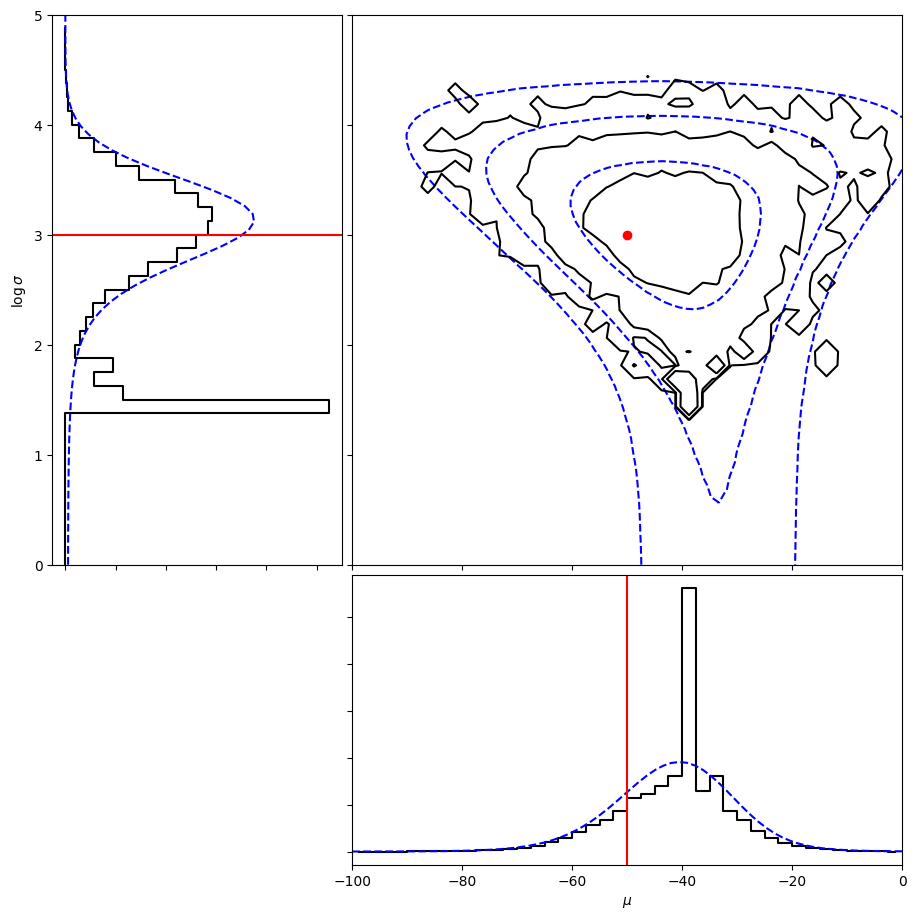

In [6]:
# adapted from textbook figure 5.27
plt.xlabel(r'${\rm v_{obs}} \, {\rm (km/s)}$')
plt.ylabel(r'${\rm measurement \, index}$')
plt.xlim(-150, 50)
plt.ylim(0, 11)
# mark +-error ranges
for i in range(0, N):
    xL = xi[i] - ei[i]
    xR = xi[i] + ei[i]
    plt.plot([xL, xR], [i + 1, i + 1], 'b', lw=2)

mu0 = np.mean(trace1['v*'], axis=0)
sig0 = np.std(trace1['v*'], axis=0)
for i in range(0, N):
    xL = mu0[i] - sig0[i]
    xR = mu0[i] + sig0[i]
    plt.plot([xL, xR], [i + 0.7, i + 0.7], 'g', lw=1)

plt.show()

plot_posterior(trace1)

...and `pymc3` is saying something about divergences and needing to reparameterize. What's the deal, and what can we do?

### Fitting a non-centered model

When $\sigma$ is small, the plausible values of $\{v_i^*\}$ are constrained to be close to $\mu$ - that is, . Thus $\{v_i^*\}$ and $\mu$ become highly covariant, and the sampler doesn't like this. We can reparameterize our problem to remove this covariance; instead of telling `pymc3`:
$$ v_i^* \sim \mathcal{N}(\mu, \sigma^2)$$
we will instead define offsets $\varepsilon_i$ that obey:
$$ \varepsilon_i \sim \mathcal{N}(0,1) \\
v_i^* = \mu + \sigma \times \varepsilon_i $$

This parameterization is mathematically equivalent, but has the advantage that the $\{\varepsilon_i\}$ will not be covariant with $\mu$. For more details, check out [this blog post by Thomas Wiecki](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/).

In [7]:
with pm.Model():
    # hyperprior
    mu = pm.Uniform('mu', -100, 0) # systemic velocity of the cluster in km/s
    log_sigma = pm.Uniform('log_sigma', 0, 5) # log of velocity dispersion in km/s
    
    # prior
    # true velocities are drawn from Gaussian(mu, sigma^2)
    eps = pm.Normal('eps', mu=0, sigma=1, shape=xi.shape) # start with a standard normal variable eps
    v_true = mu + eps * np.exp(log_sigma) # express v_true = mu + eps * sigma
    
    #likelihood
    v = pm.Normal('v', mu=v_true, sigma=ei, observed=xi) # xi are measurements of true velocities with gaussian errors ei
    
    #sample!
    trace2 = pm.sample(draws=10000, tune=1000, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, log_sigma, mu]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 13 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


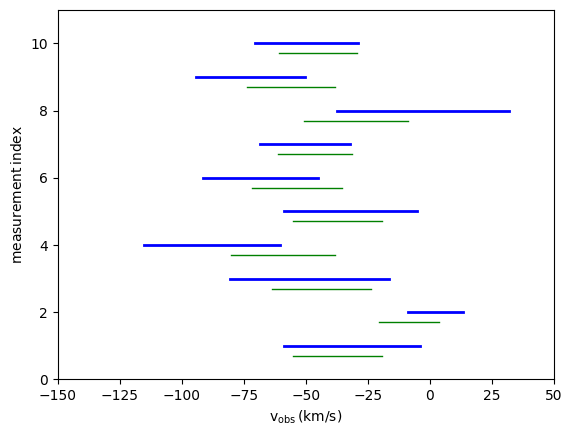

/opt/conda/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


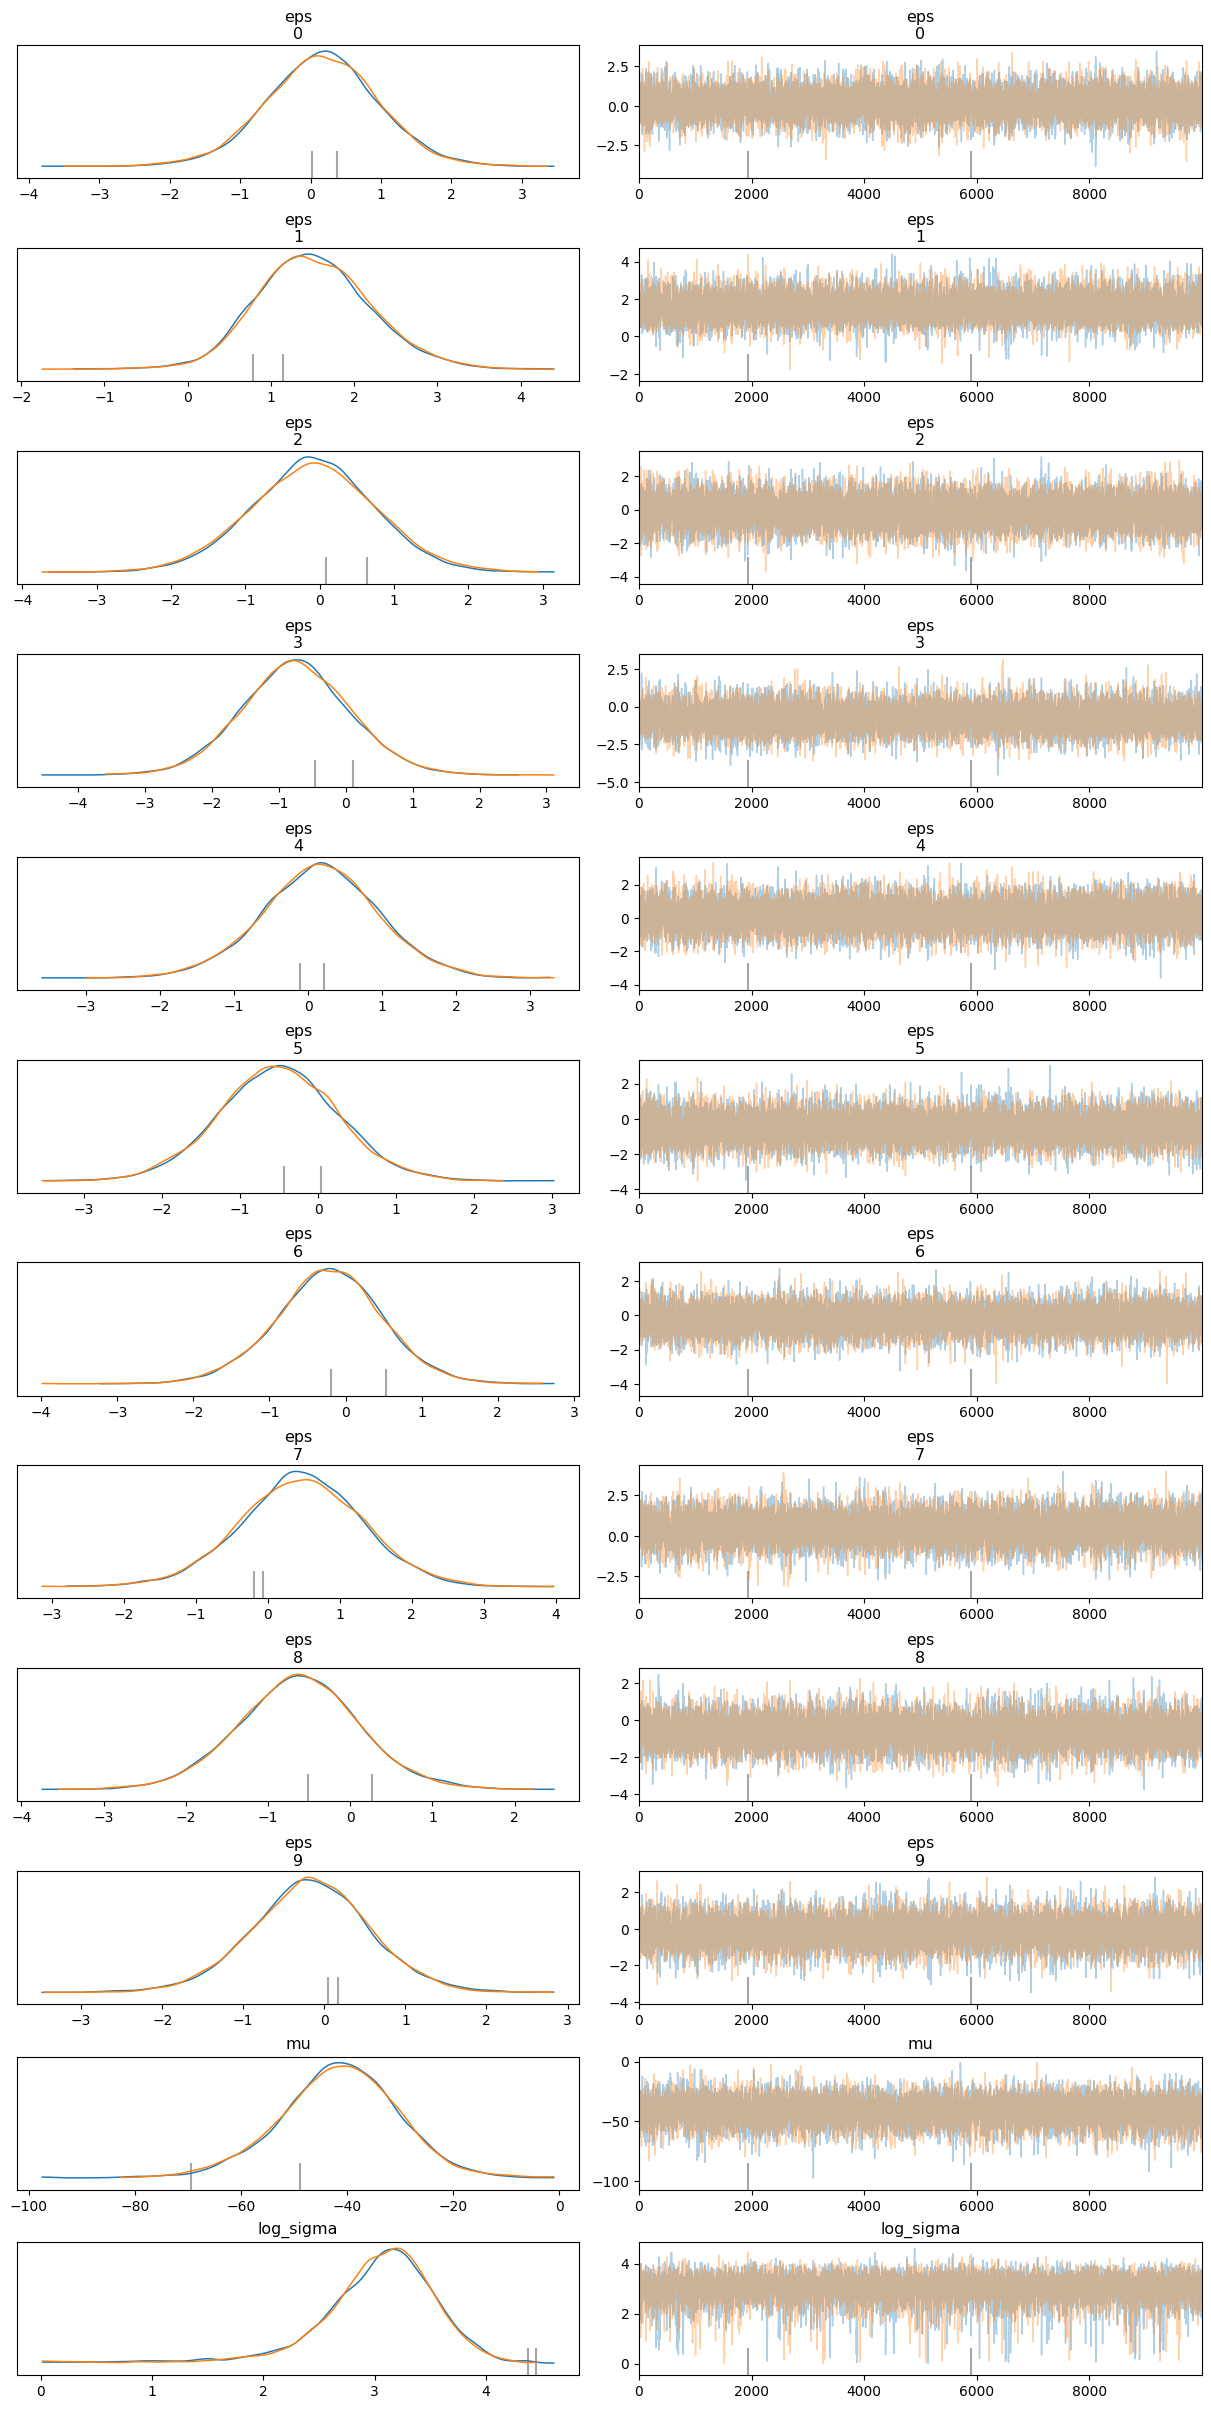

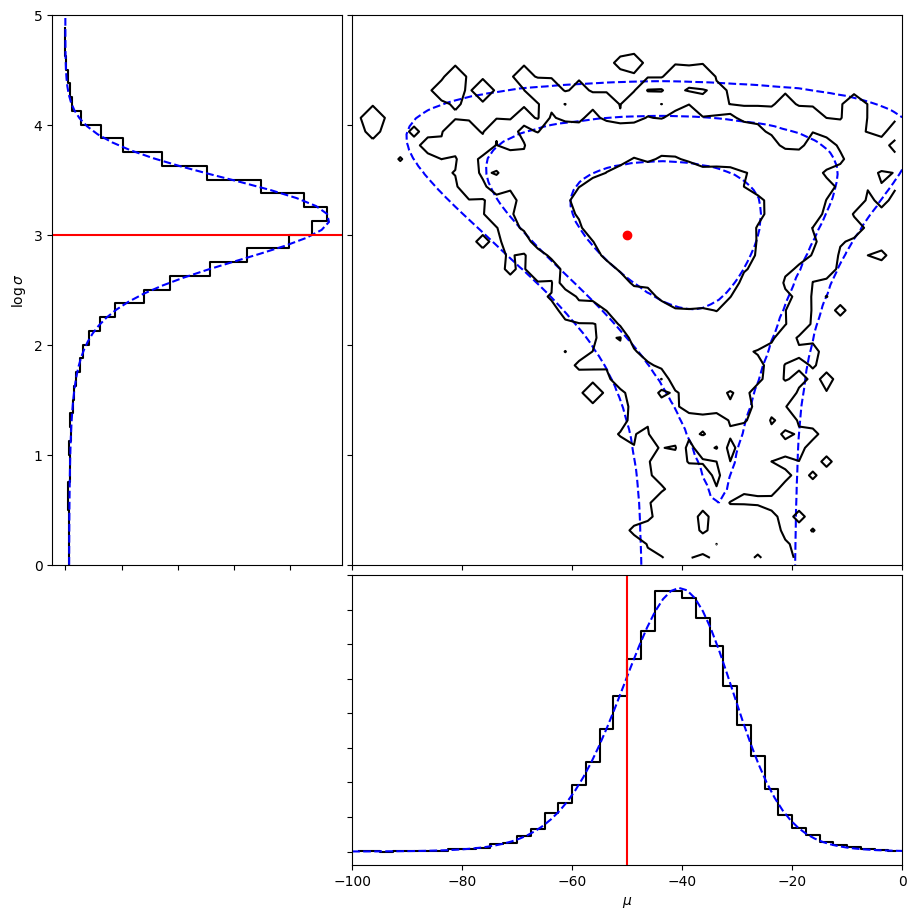

In [8]:
# adapted from textbook figure 5.27
plt.xlabel(r'${\rm v_{obs}} \, {\rm (km/s)}$')
plt.ylabel(r'${\rm measurement \, index}$')
plt.xlim(-150, 50)
plt.ylim(0, 11)
# mark +-error ranges
for i in range(0, N):
    xL = xi[i] - ei[i]
    xR = xi[i] + ei[i]
    plt.plot([xL, xR], [i + 1, i + 1], 'b', lw=2)

# transform from epsilon to v*
mu0 = np.mean(trace2['mu'][:,None] + trace2['eps'] * np.exp(trace2['log_sigma'])[:,None], axis=0)
sig0 = np.std(trace2['mu'][:,None] + trace2['eps'] * np.exp(trace2['log_sigma'])[:,None], axis=0)

for i in range(0, N):
    xL = mu0[i] - sig0[i]
    xR = mu0[i] + sig0[i]
    plt.plot([xL, xR], [i + 0.7, i + 0.7], 'g', lw=1)

plt.show()

plot_posterior(trace2)

There's fewer divergences, and the outer contours of the joint $\mu, \sigma$ posterior looks more filled out! We just have to do a little bit of work to get samples of $v_i^* = \mu + \varepsilon_i \times \sigma$.

### Exercise: using the marginal likelihood

We can make this inference even faster by taking advantage of our analytic derivation that the likelihood for star $i$ marginalized over its true velocity $v_i^*$ is:
$$v_i \mid e_i, \mu, \sigma \sim \mathcal{N}(\mu, e_i^2 + \sigma^2)$$
Remove the prior from the `pymc3` model and replace the likelihood with this marginalized likelihood. 

Got error No model on context stack. trying to find log_likelihood in translation.
/opt/conda/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


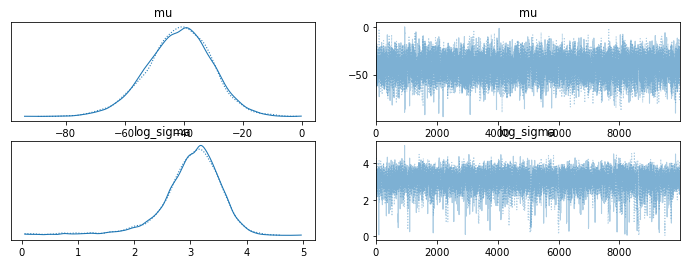

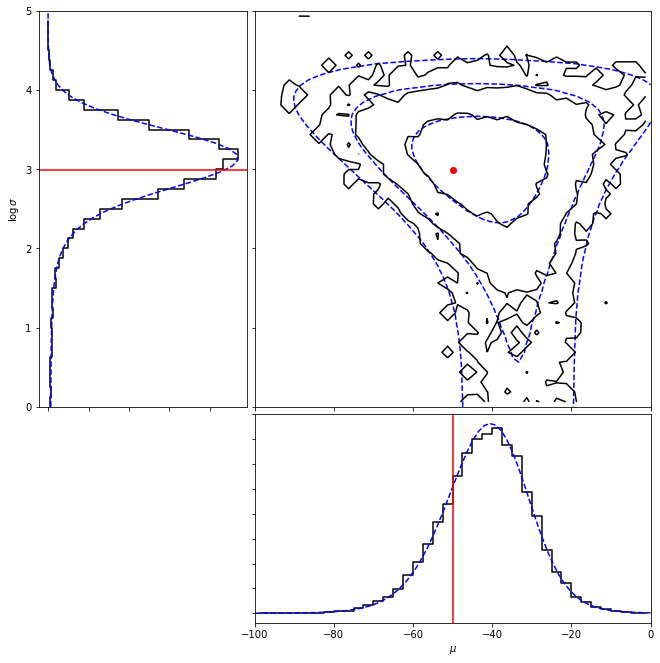

In [11]:
plot_posterior(trace3)

This chain will not sample $v_i$. Use
$$ v_i^* \mid v_i, e_i, \mu, \sigma \sim \mathcal{N}\left(\frac{v_i/e_i^2 + \mu/\sigma^2}{1/e_i^2 + 1/\sigma^2}, \frac{1}{1/e_i^2 + 1/\sigma^2}\right)$$
to obtain samples of $v_i$ from the chain's samples of $\mu$ and $\sigma$.